# Out-of-plane failure calculations
### G-Mechanism Parish House East Facade

Author: Aline F. Bönzli

Master Thesis 2023/2024

Supervisors: Prof. Dr. Katrin Beyer, Dr. Igor Tomic

Co-author: Caroline L. Heitmann

Caroline and I intensely collaborated on the elaboration of various notebooks for different OOP mechanisms, generic and specifically applied to our respective buildings treated in our theses.

## Introduction

This notebook can be used to calculate the push-over curve for an out-of-plane mechanisms of a masonry structure subject to seismic action. The mechanism in question is a G-mechanism (D'Ayala, 2002) and the calculations were performed for the east facade of the Parish House at St. Lawrence Church in Petrinja, Croatia. 

First, the geometric and material characteristics will be defined, then depending on these inputs, the displacement capacity for out-of-plane accelerations will be returned in form of a push-over graph. 

In [7]:
# Import the basic packages for the notebook
import numpy as np                   # Numerical library
import pandas as pd                  # Data analysis library
import matplotlib.pyplot as plt      # Plotting library
import matplotlib.ticker as maticker # Tick locating and formatting library
import matplotlib.colors as mcolors  # Colours
from sympy.solvers import solvers    # Library to solve equations
from sympy import Symbol, Eq, nsolve # For solving equations
import math

## 1. Define the wall geometry

The chosen example for this code is a plain wall moving out of plane around two diagonal axes. The diagonal cracks going through the window, as well as two vertical cracks separate the wall in three blocks. A sketch with the main dimensions is shown below. The displacement delta is measured at the center of the wall.

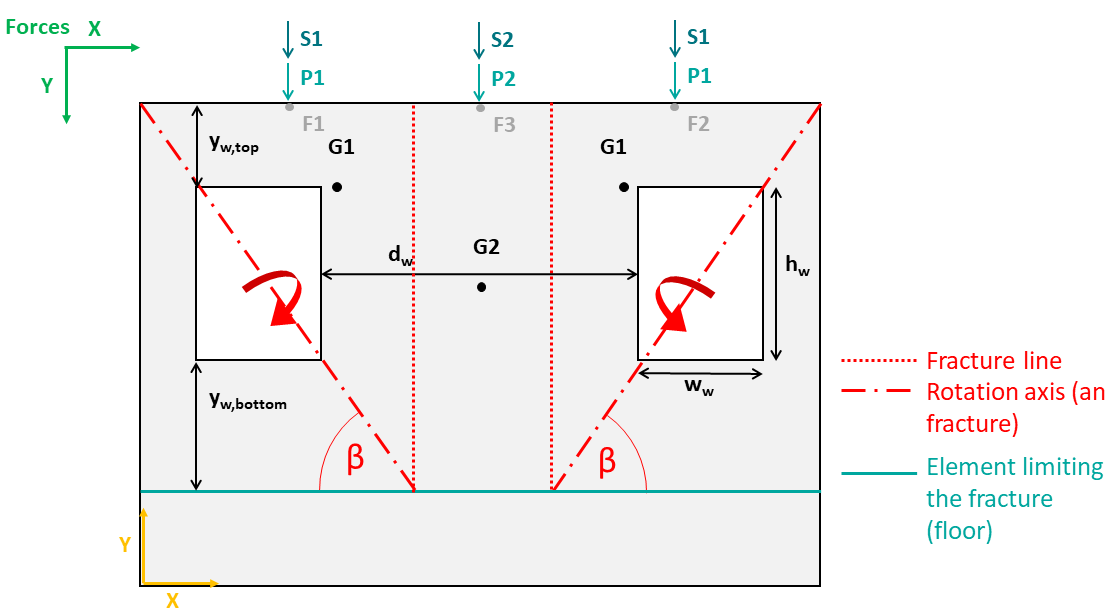

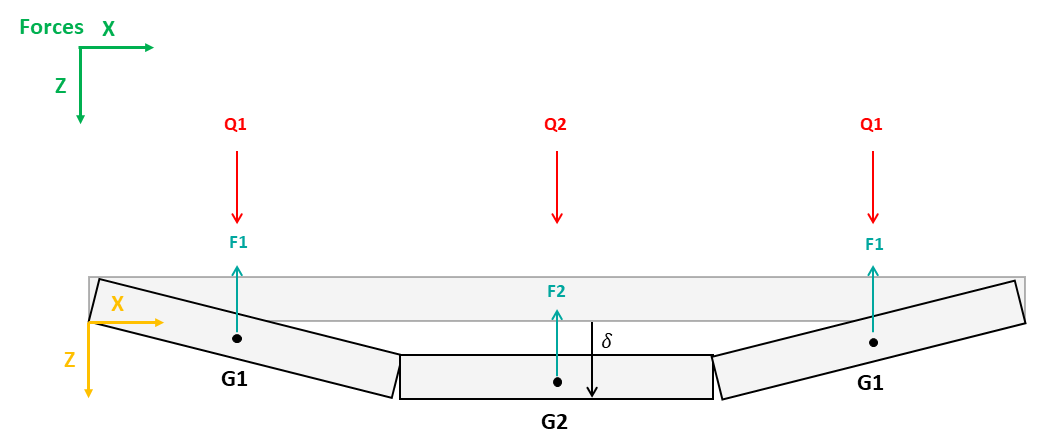

In [8]:
from IPython.display import Image, display
display(Image(filename='Mec_G_4.png'))
display(Image(filename='Mec_G_5.png'))

This block is used to define the geometry of the wall and the windows within.

In [9]:
## Wall geometry
y_w_top = 0.65      # Free space above window (until reaching next floor), y-direction [m]
y_w_bottom = 0.9    # Free space below window (until reaching next floor), y-direction [m]
d_w = 2.9           # Horizontal distance between the windows in the mechanism,x-direction [m]
h_w = 1.7           # Height of the window, y-direction [m]
w_w = 1.1           # Width of the window, x-direction
t = 0.55            # Thickness of wall,    z-direction [m]
# since it is a symmetric mechanism, it is considered that the cracks go from the upper limit of the wall, through
# the two diagonal corners of a window until reaching the crack from the other side.

## Slab information
max_delta = t/2     # Maximum drift (at the center crack), when the slab and wall loose connection and the friction between the two of them 
                    # is no longer restraining the wall [m]

## 2. Define material properties

This block is used to define the material properties of the wall and the connecting slab. You can adapt the input to use the notebook 
for different cases.

In [10]:
rho_masonry = 18000         # Density of the masonry [N/m^3]
mu_f = 0.7                  # Friction coefficient between slab and masonry wall

## 3. Define the loads and forces

In this paragraph, the loads and forces acting on the wall are defined. The following block defines the vertical load on top of the wall coming from a slab (S) or a superimposed wall (P). Note that the S-load will be used to directly calculate the restraining force due to friction between the wall and the slab. If you want to introduce a vertical load that does not produce any friction, please use the P-load.

In [11]:
P1 = 11305             # vertical load on top of each triangular block [N]
S1 = 19000             # slab load acting on top of each triangular block [N]
P2 = 9329              # vertical load on top of the middle block [N]
S2 = 15678             # slab load acting on top of the middle block [N]

## 4. Calculation of overturning moment

This paragraph calculates the pushover curve for the given case.

The maximum forces on each block are: Q1= 12.46kN Q2=90.82kN
After reaching that limit, the wall will start rocking out of plane.
This corresponds to acelerations of acc= 15.96m/s2
The a-factor is a1=1.6265672026107196 
The limit displacement corresponds to 0.569 m. After reaching this displacement the wall loses all resistance.


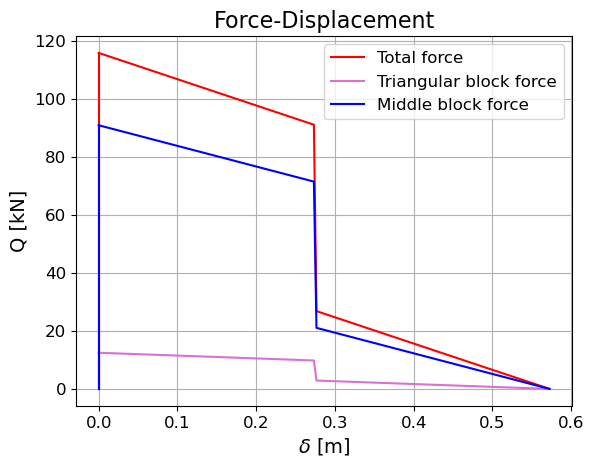

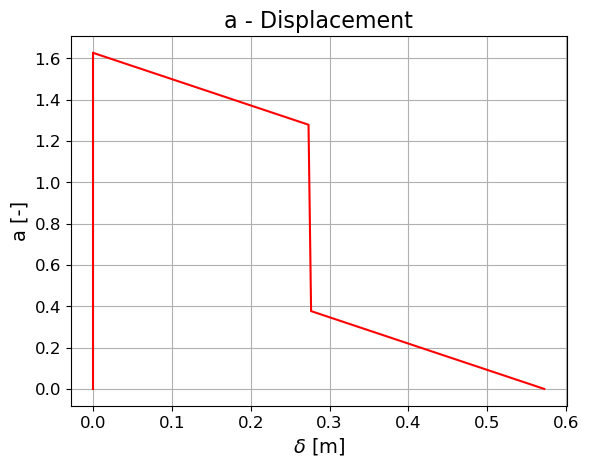

In [12]:
# This function calculates lever arm between the center of gravity of a triangular wall and the rotation axis
def lever_arm(x,y):
    # H   = Total height of wall, y-direction [m]
    # L   = Total length of wall, x-direction [m]
    # t   = Thickness of wall,    z-direction [m]
    # x   = X-coordinate of the point for which the lever arm is searched [m]
    # y   = Y-coordinate of the point for which the lever arm is searched [m]
    y_top = H - y # Distance from top edge to center of gravity
    if x <= L/2:
        z_lever = (x * np.sin(beta)) - (y_top * np.cos(beta))
    else:
        x_bar = L-x 
        z_lever = (x_bar * np.sin(beta)) - (y_top * np.cos(beta))

    return z_lever

# This function calculates the center of gravity of the moving triangular block, considering the opening of the window
def COG_calc():
    # H          = Total height of wall, y-direction [m]
    # L          = Total length of wall, x-direction [m]
    # t          = Thickness of wall,    z-direction [m]
    # h_w        = Height of the window, y-direction [m]
    # w_w        = Width of the window,  x-direction [m]
    # x_w_out    = Distance between outer window edge and end of mechanism (horizontal) [m]
    # y_w_top    = Distance between upper edge of window and floor (vertical) [m]
    # y_w_bottom = Distance between bottom edge of window and end of mechanism (vertical)[m]
    # d_w        = Distance between the windows [m]
    COG_wall = np.array([2*L/3,2*H/3])
    COG_window = np.array([x_w_out + (2*w_w/3),y_w_bottom + (2*h_w/3)])

    V_brut = H*L/2*t                            # volume of the moving wall block[m3]
    V_window =h_w*w_w/2*t                       # volume of opening in moving block [m3]
    V_net = V_brut - V_window                   # volume of the moving block without window volume [m3]

    COG_tot= ((COG_wall * V_brut) - (COG_window*V_window))/V_net
    return COG_tot


# This function calculates the maximum horizontal force that can be applied to the wall at a given deformation delta 
# to stay in an equilibrium state
def alpha_fun(delta): 
    # delta        = Displacement at the top of the wall [m]
    delta_top_center = delta * z_top_center / z_delta
    delta_cog = delta * z_cog / z_delta
    delta_midblock2 = delta * z_midblock2/H


    if delta >= max_delta:
        F1_proj = 0
        F2_proj = 0
    else:
        F1_proj = F1
        F2_proj = F2
    
    # Define the symbol for the acceleration
    a = Symbol('a')
    

    # Define the equation
    equation = Eq(2*a*G1*z_cog/z_delta                                  # Seismic force on triangular blocks 
                - 2*F1_proj*z_top_center/z_delta                        # Friction force on triangular blocks
                + 2*G1_proj*(delta_cog-(t/2))/z_delta                   # Gravity force on triangular blocks
                + 2*P1_proj*(delta_top_center-(t/2))/z_delta            # Vertical load on triangular blocks
                + 2*S1_proj*(delta_top_center-(t/2))/z_delta            # Slab load on triangular blocks
                + a*G2/2                                              # Seismic force on middle block
                - F2_proj                                               # Friction force on middle block
                + G2*(delta-t)/2/H                                      # Gravity force on middle block
                + P2*(delta-(t/2))/H                                    # Vertical load on middle block
                + S2*(delta-(t/2))/H                                    # Slab load on middle block       
                ,0)

    # Use nsolve to find the solution
    a_sol = nsolve(equation, a, 1.0)
    return a_sol

## Derived wall properties
beta = np.arctan(h_w/w_w)                   # angle of the crack
x_w_out = y_w_top / np.tan(beta)            # horizontal distance from corner of window to outer end of crack [m]
x_w_in = y_w_bottom / np.tan(beta)          # vertical distance from bottom of window to crack intersection [m]
L_mid = d_w - (2*x_w_in)                    # length of the middle block [m]
L_t = w_w + x_w_in + x_w_out                # length of the triangular blocks [m]
#print(L_t)
#print(L_mid)

H = h_w + y_w_top + y_w_bottom              # total height of the mechanism [m]
L = w_w + x_w_out + x_w_in                  # total length of the triangular block [m]

V_brut_t = H*L_t/4*t                        # volume of the moving wall block[m3]
V_window_t =h_w*w_w/2*t                     # volume of opening in moving block [m3]
V_net_t = V_brut_t - V_window_t             # volume of the moving block without window volume [m3]

V_net_mid = H * L_mid * t                   # volume of the middle block

COG = COG_calc()                            # center of gravity of the moving block (x,y) [m]

z_top_center = lever_arm(L/4,H)
z_cog = lever_arm(COG[0],COG[1])
z_delta = lever_arm(L/2,H)
z_midblock2 =H/2

## Derived loads and forces
G1 = rho_masonry*V_net_t                   # gravity load of the outer triangular walls (self-weight) [N]
G2 = rho_masonry*V_net_mid                 # gravity load of the middle wall (self-weight) [N]
F1 = mu_f*S1                               # friction force from slab acting on top of the outer triangular walls [N]
F2 = mu_f*S2                               # friction force from slab acting on top of the middle wall [N]
# The projected parts of the actions that will create a moment around the turning axis
P1_proj = P1 * np.cos(beta)
S1_proj = S1 * np.cos(beta)
G1_proj = G1 * np.cos(beta)

## Rocking 
# Maximum earthquake force to start rocking 
alpha_max  = alpha_fun(0)                  # Portion of gravity load [-]
Q1_max = G1*alpha_max/1000                 # Maximum seismic load on triangular blocks [N]
Q2_max = G2*alpha_max/1000                 # Maximum seismic load on middle block [N]
Q_tot_max=2*Q1_max+Q2_max

# Plot force-displacement relationship of the left overturning of the wall
delta_vals = np.linspace(0,H,1000)
alpha_vals = np.zeros((np.size(delta_vals)))

for i in range(np.size(delta_vals)):        # Calculates the corresponding alpha factor for the given displacement 
                                            # at the COG of the triangular parts of the wall
    alpha_vals[i]=alpha_fun(delta_vals[i])

# Transformation to only display values up to failure
alpha_vals = alpha_vals[alpha_vals>=0]
delta_vals = delta_vals[: np.size(alpha_vals)]

# Calculate the forces corresponding to the alpha factors on each block
q1_vals=alpha_vals*G1/1000                 # Seismic force on triangular block [kN]
q2_vals=alpha_vals*G2/1000                 # Seismic force on middle block [kN]
q_tot_vals=2*q1_vals+q2_vals

plt.figure()
plt.grid()
plt.plot([0,0],[0,Q_tot_max],label='Total force',color='red')
plt.plot(delta_vals,q_tot_vals,color='red')
plt.plot([0,0],[0,Q1_max],label='Triangular block force',color='orchid')
plt.plot(delta_vals,q1_vals,color='orchid')
plt.plot([0,0],[0,Q2_max],label='Middle block force',color='blue')
plt.plot(delta_vals,q2_vals, color='blue')

plt.legend(fontsize=12)
plt.xlabel('$\delta$ [m]', fontsize=14)
plt.ylabel('Q [kN]', fontsize=14)
plt.title('Force-Displacement', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



# Plot acceleration-displacement relationship of the overturning of the wall, where alpha is a factor multiplied
# by gravitational force
plt.figure()
plt.grid()
plt.plot([0,0],[0,alpha_max],color='red')
plt.plot(delta_vals,alpha_vals,color='red')

plt.xlabel('$\delta$ [m]', fontsize=14)
plt.ylabel('a [-]', fontsize=14)
plt.title('a - Displacement', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Maximum earthquake force to start rocking
a_max = alpha_vals[0]                     # Maximum alpha [-]
acc_max = a_max*9.81                      # Maximm acceleration [-]
delta_max = delta_vals[-2]                # Maximum displacemet [m]

print(f"The maximum forces on each block are: Q1= {round(Q1_max,2)}kN Q2={round(Q2_max,2)}kN")
print('After reaching that limit, the wall will start rocking out of plane.')
print('This corresponds to acelerations of acc= '+str(round(acc_max,2))+'m/s2')
print(f"The a-factor is a1={a_max} ")
print('The limit displacement corresponds to '+str(round(delta_max,3))+' m. After reaching this displacement the wall loses all resistance.')


## 5. Computation of capacity curve

This section allows the analysis of the structural response in the context of the seismic spectrum. The goal is to compare the capacity curve to the ADRS response spectrum, which will allow the behaviour of the wall to be interpreted (e.g., indicating whether it would meet its design requirements).

The main input is the spectral acceleration (for a 475-year return period) for the wall in its given location, as well as its period. For users of the Swiss code, SIA 261 chapter 16.2.1.2 provides the horizontal soil acceleration for each seismic zone; otherwise it can be found in the relevant National Annex of the Eurocode.

As stated above, this section will provide an interpretation of the wall's behavior according to a trilinear force-displacement model. These model utilizes three points: two displacement parameters, delta_1 and delta_2, and the maximum displacement As stated above, this section will provide an interpretation of the wall's behavior according to a trilinear force-displacement model. These model utilizes three points: two displacement parameters, $\Delta_1$ and $\Delta_2$, and the maximum displacement capacity, $\Delta_o$. Below, the trilinear approximation as determined by Griffith et al. (2003) is plotted alongside the bilinear relationship and the real semi-rigid nonlinear relationship. According to Griffith et al. (2003), these coefficients depend on the material quality. Note that for this notebook, $\Delta_u$ is approximated to be equivalent to $\Delta_o$ in this code., delta_o. Below, the trilinear approximation as determined by Griffith et al. (2003) is plotted alongside the bilinear relationship and the real semi-rigid nonlinear relationship. According to Griffith et al. (2003), these coefficients depend on the material quality. Note that for this notebook, delta_u is approximated to be equivalent to delta_o in this code.

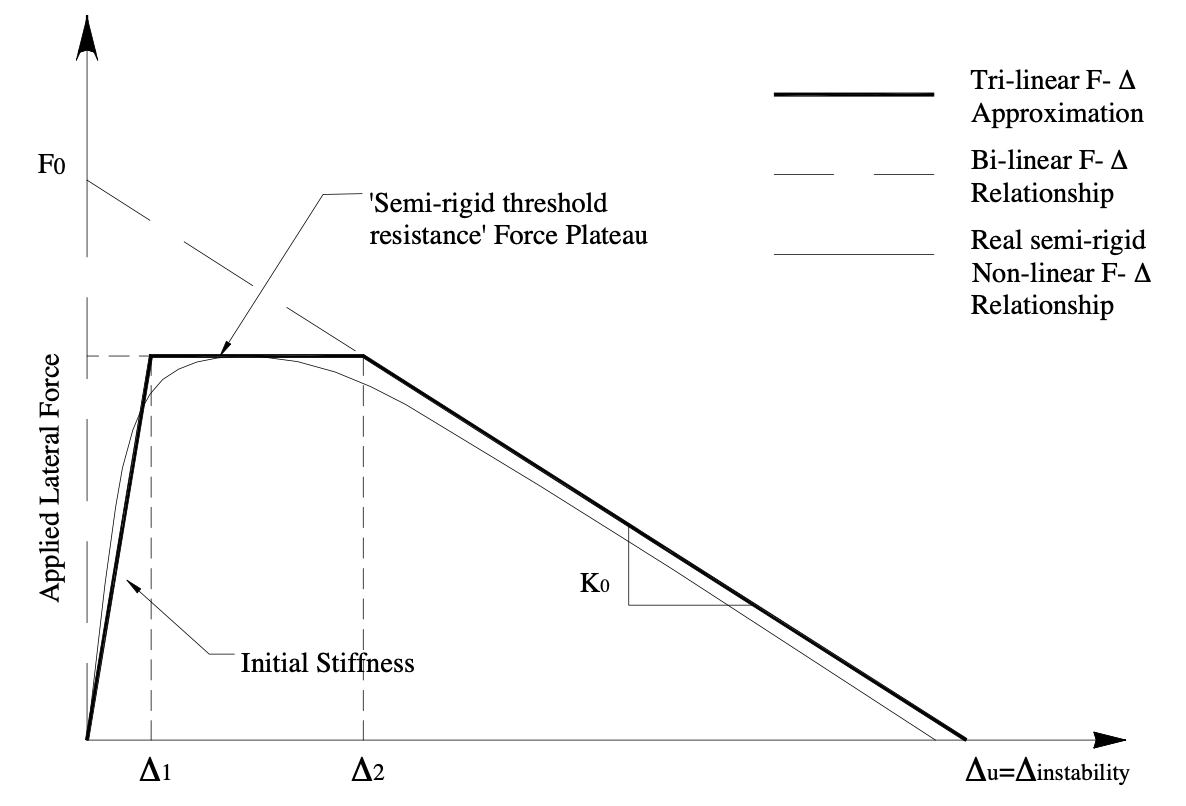

In [13]:
display(Image(filename='Griffith_Trilinear.png'))

In [14]:
agr = 0.152        # Spectral acceleration for 475-year return period [g]

# Choose the coefficients for the tri-linear model per Griffith et al. (2003)
d1 = 0.075         # Range from 0.05 to 0.20
d2 = 0.47          # Range from 0.25 to 0.50

Response spectra are defined for single degree of freedom (DOF) systems. In this case, the mechanism involves more than one DOF. Thus, the capacity curve needs to be transformed into a capaciti curve for an equivalent SDOF system. Furthermore, after the transformation the pushover curve is aproximated as a tri-linear curve as proposed above (Griffith et al., 2003).

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

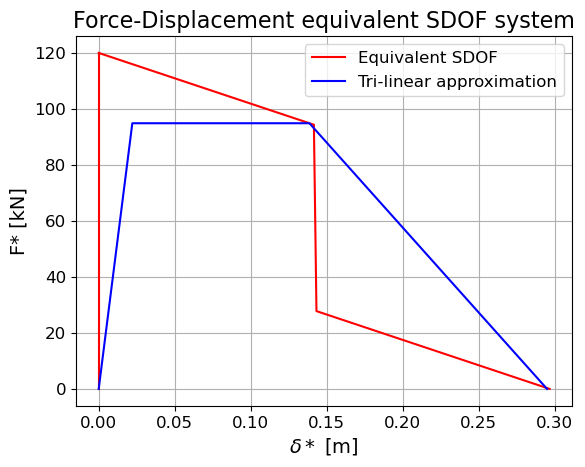

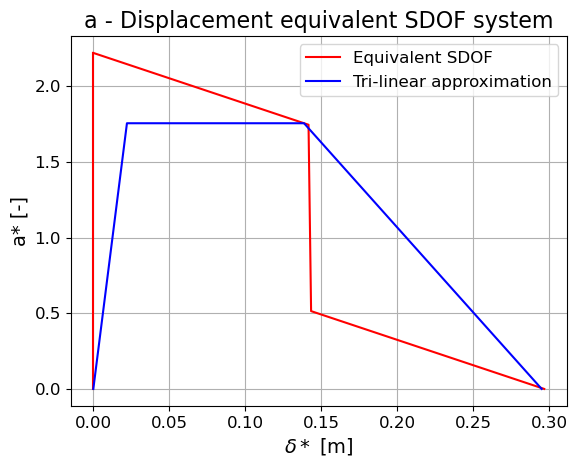

In [15]:
m = np.array([V_net_t,V_net_mid,V_net_t])*rho_masonry       # mass of wall [kg]
g = 9.81                                                   # gravitational constant [m/s^2]
Qs = np.sum(m)*agr*g                                       # seismic force acting at the gravity center of the wall [N]
phi = np.divide([z_cog/z_delta, z_midblock2/H, z_cog/z_delta],z_midblock2/H)       # modal shape

# calculate effective properties
m_star = np.dot(m,phi)                                     # effective mass (SDOF) [kg]
Gamma = m_star / np.dot(m,phi**2)                          # participation factor [-]
Fb = q_tot_vals * 1000                                     # total shear force [N]
F_star = Fb/Gamma                                          # equivalent shear force [N]
d_2 = delta_vals/H*z_midblock2                             # displacement at COG of rectangular block [m]
phi2 = phi[1]                                              # modal value at COG of rectangular block [-]
d_star = d_2/(Gamma*phi2)
a_star = F_star/m_star                                     # effective acceleration (SDOF) [m/s^2]

# Tri-linear approximation of the pushover curve according to  Griffith et al. (2003)
a_1 = alpha_fun(d1*delta_max)
a_2 = alpha_fun(d2*delta_max)
F_star1 = a_1*(2*G1+G2)/Gamma
F_star2 = a_2*(2*G1+G2)/Gamma
a_star1 = F_star1/m_star
a_star2 = F_star2/m_star
d_star1 = (d1*delta_max)/H*z_midblock2/(Gamma*phi2)
d_star2 = (d2*delta_max)/H*z_midblock2/(Gamma*phi2)
d_star_max = d_star[-2]
F_star_max = F_star2
F_star_app = [0,F_star_max, F_star_max,0]
d_star_app = [0,d_star1,d_star2,d_star_max]
a_star_app = F_star_app/m_star
a_star_max = F_star_max/m_star

# Displacement capacities according to EN 1998-3
d_u1 = 0.4*d_star_max
d_u2 = 0.6*d_star_max

# Pushover curve of the equivalent SDOF Force-Displacement
plt.figure()
plt.grid()
plt.plot([0,0],[0,F_star[0]/1000],color='red')
plt.plot(d_star,np.divide(F_star,1000),label='Equivalent SDOF',color='red')
plt.plot(d_star_app,np.divide(F_star_app,1000),label='Tri-linear approximation',color='blue')

plt.legend(fontsize=12)
plt.xlabel('$\delta*$ [m]', fontsize=14)
plt.ylabel('F* [kN]', fontsize=14)
plt.title('Force-Displacement equivalent SDOF system', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Pushover curve of the equivalent SDOF Acceleration-Displacement
plt.figure()
plt.grid()
plt.plot([0,0],[0,a_star[0]],color='red')
plt.plot(d_star,a_star,label='Equivalent SDOF',color='red')
plt.plot(d_star_app,a_star_app,label='Tri-linear approximation',color='blue')

plt.legend(fontsize=12)
plt.xlabel('$\delta*$ [m]', fontsize=14)
plt.ylabel('a* [-]', fontsize=14)
plt.title('a - Displacement equivalent SDOF system', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

To compute the response spectrum, it is necessary to specify the soil type per SIA 261 Tableau 24 or the Eurocode National Annex for a particular country.

Alternatively, sometimes the response spectra are defined according to the limit state for analysis. The available limit states are: 'serviceability', 'damage limitation', 'significant damage' or 'near collapse. More information can be found in EC 8 chapter 4.2.3. 

After the computation of the response spectrum, the capacity curve of the equivalent SDOF system can be plotted alongside the acceleration-displacement response spectrum. This provides a direct comparison between the specific behavior of the elements in question (in this case, the wall) and the spectrum of the desired limit state (either serviceability state, damage limitation, significant damage, or near collapse), and it can quickly give the spectral acceleration for a certain spectral displacement. 

This displacement-based evaluation utilizes the equal displacement "rule" for periods smaller than $T_c$ and the equal energy "rule" for periods larger than $T_c$. Thus, to interpret the results, extend the initial positive linear part of the capacity curve until it intersects the ADRS, and draw a vertical line at this intersection. If $T < T_c$, the actual displacement will be slightly larger than the displacement at the intersection of the capacity curve and the vertical line; if $T > T_c$, the actual displacement will be equivalent to the displacement at the intersection of the capacity curve and the vertical line. The displacement capacity is exceeded if the determined displacement is larger than the end of the capacity curve. 

In [16]:
soil_type = 'E'        # specify the soil type (ranging from A to E)

In [17]:
### NOTHING TO BE CHANGED

## Determine the periods that define the spectrum according to the soil type, with values from SIA 261 Tab. 24
def spectrum_vals(soil_type): 
    if soil_type == 'A':
        S = 1.00                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.40                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'B':
        S = 1.20                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'C':
        S = 1.15                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.60                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'D':
        S = 1.35                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.80                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'E':
        S = 1.40                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    
    return S,Tb,Tc,Td

## Determine the spectral acceleration according to the structure's fundamental period
def RS(T,agr,S,Tb,Tc,Td):

    # determine spectral ground acceleration for dimensionning 
    g = 9.81                                     # [m/s^2]
    agd = agr*g                                  # [m/s^2]
    zeta = 0.05                                  # assume damping ratio to be 5% [-]
    eta = max(np.sqrt(1/(0.5+10*zeta)),0.55)     # reduction coefficent [-]

    # compute spectrum according to period
    if T<Tb: 
        Se = agd*S*(1+(T/Tb)*(eta*2.5-1))
    elif T>=Tb and T<Tc:
        Se = agd*S*eta*2.5
    elif T>=Tc and T<Td:
        Se = agd*S*eta*2.5*(Tc/T)
    else:
        Se = agd*S*eta*2.5*(Tc*Td/T**2)

    return Se

The target displacement NC is of d=0.047 m
The NC limit displacement is d_u2=0.177 m
Therefore the NC limit state is verified


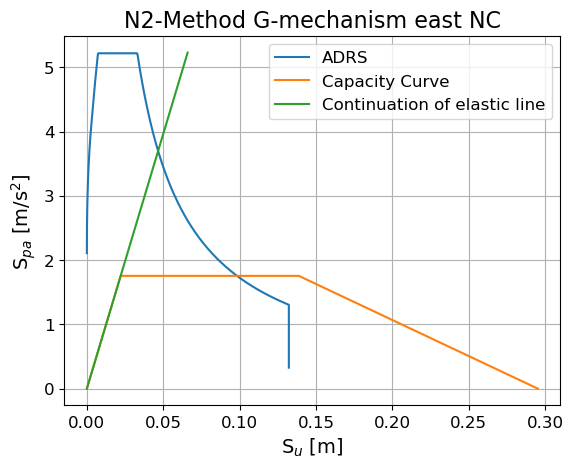

In [18]:
## Compute ADRS
# Initialize vectors
T_vals = np.linspace(0.001,4,1000)
Su_vals = np.zeros((len(T_vals),1))
Se_vals = np.zeros((len(T_vals),1))
[S,Tb,Tc,Td] = spectrum_vals(soil_type)

for i in range(0,1000):
    omega = 2*np.pi/T_vals[i]                                           # natural frequency [rad/s]
    Se_vals[i] = RS(T_vals[i],agr,S,Tb,Tc,Td)                           # spectral acceleration [m/s^2]
    if T_vals[i] < Tc: 
        Ry = max(Se_vals[i]*m_star/Qs,1)                                # R relationship [-]
        wd_int = ((Ry-1)*Tc/T_vals[i] + 1)*Se_vals[i]/((omega**2)*Ry)   # displacement capacity [m]
        Su_vals[i] = min(wd_int,3*Se_vals[i]/omega**2)                  # spectral displacement capacity [m]
    else:
        Su_vals[i] = Se_vals[i]/(omega**2)                              # spectral displacement capacity [m]

## Plot capacity curve NC
# plot results
plt.figure()
plt.grid()
plt.plot(Su_vals,Se_vals,label='ADRS')
plt.plot(d_star_app,a_star_app,label='Capacity Curve')
plt.plot(Su_vals[:round(len(Su_vals)/4)],Su_vals[:round(len(Su_vals)/4)]/d_star1*a_star_max,label="Continuation of elastic line")
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('S$_u$ [m]', fontsize=14)
plt.ylabel('S$_{pa}$ [m/s$^2$]', fontsize=14)
plt.title('N2-Method G-mechanism east NC', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

def find_closest_pair(d1, f1, d2, f2):
    
    data_set1 = np.column_stack((d1, f1))
    data_set2 = np.column_stack((d2, f2))

    min_distance = float('inf')
    closest_pair = None

    for point1 in data_set1:
        for point2 in data_set2:
            dist2d =point1 - point2
            distance = (dist2d[0]**2+dist2d[1]**2)**0.5
            if distance < min_distance:
                min_distance = distance
                closest_pair = (point1[0], point1[1], point2[0], point2[1])

    return closest_pair


closest = find_closest_pair(Su_vals, Se_vals, Su_vals[:round(len(Su_vals)/2)],Su_vals[:round(len(Su_vals)/2)]/d_star1*a_star_max)
target_disp_NC = (closest[0]+closest[2])/2

print(f"The target displacement NC is of d={round(target_disp_NC,3)} m")
print(f"The NC limit displacement is d_u2={round(d_u2,3)} m")
if target_disp_NC<=d_u2:
    print('Therefore the NC limit state is verified')
else:
    print('Therefore the NC limit state is NOT verified!!!!')

The target displacement DL is of d=0.023 m
The DL limit displacement is d_u1=0.118 m
Therefore the DL limit state is verified


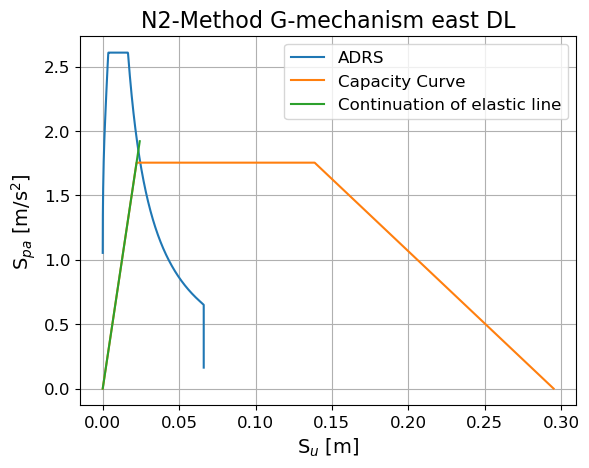

In [19]:
## Plot capacity curve DL
# plot results
plt.figure()
plt.grid()
plt.plot(0.5*Su_vals,0.5*Se_vals,label='ADRS')
plt.plot(d_star_app,a_star_app,label='Capacity Curve')
plt.plot(Su_vals[:round(len(Su_vals)/10)],Su_vals[:round(len(Su_vals)/10)]/d_star1*a_star_max,label="Continuation of elastic line")
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('S$_u$ [m]', fontsize=14)
plt.ylabel('S$_{pa}$ [m/s$^2$]', fontsize=14)
plt.title('N2-Method G-mechanism east DL', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

closest = find_closest_pair(0.5*Su_vals, 0.5*Se_vals, Su_vals[:round(len(Su_vals)/10)],Su_vals[:round(len(Su_vals)/10)]/d_star1*a_star_max)
target_disp_DL = (closest[0]+closest[2])/2

print(f"The target displacement DL is of d={round(target_disp_DL,3)} m")
print(f"The DL limit displacement is d_u1={round(d_u1,3)} m")
if target_disp_DL<=d_u1:
    print('Therefore the DL limit state is verified')
else:
    print('Therefore the DL limit state is NOT verified!!!!')



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec31d9b1-b904-46de-90ff-bc7ed068e5e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>